# Multi-fidelity GP surrogate model

## General settings

We begin by importing the necessary libraries and adjust settings for plotting:

In [ ]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from matplotlib import colors as mcolors
from IPython.display import clear_output

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
%matplotlib inline

np.random.seed(20)

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

Next, we install the Emukit package and import the associated packages:

In [ ]:
!pip install emukit
clear_output()
print('Emukit installed')

Emukit installed


In [ ]:
# Emukit imports
import GPy
import emukit.multi_fidelity
import emukit.test_functions
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
import emukit.test_functions.multi_fidelity

## Import datasets files

Next, we import and load the high (HF) and low fidelity (LF) datasets. Each sample/observations of both datasets consists in an input and output array of the form:

\begin{array}{cc}
\text{Input} & \text{Output}\\
[ c, \beta, c_1, c_3, k, K_s ] & [ \mathrm{C_{rs}}, \mathrm{R} ]
\end{array}
\
,where the input contains our six model parameters ($c$, $\beta$, $c_1$ and $c_3$ from the tissue constitutive model + permeability $k$ + chest wall stiffness $K_s$) and the output our two variables that represent the lung response (respiratory system compliance $\mathrm{C_{rs}}$ and airways resistance $\mathrm{R}$).

\
- For the surrogate model training, we have 20 HF samples and 200 LF samples.

- For the surrogate model testing, we have 100 HF and LF samples (both with the same input).

Getting files from repository

In [ ]:
!wget https://raw.githubusercontent.com/josebarahonay/datos/master/training_input_data_20_hf.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos/master/training_output_data_20_hf.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos/master/testing_input_data_100_hf.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos/master/testing_output_data_100_hf.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos/master/training_input_data_200_lf.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos/master/training_output_data_200_lf.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos/master/testing_input_data_100_lf.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos/master/testing_output_data_100_lf.npy

clear_output()

In [ ]:
# High Fidelity (HF) and Low Fidelity (LF) training datasets
X_hf = np.load('training_input_data_20_hf.npy')
Y_hf = np.load('training_output_data_20_hf.npy')

X_lf = np.load('training_input_data_200_lf.npy')
Y_lf = np.load('training_output_data_200_lf.npy')

# High Fidelity (HF) and Low Fidelity (LF) testing datasets
X_hf_100 = np.load('testing_input_data_100_hf.npy')
Y_hf_100 = np.load('testing_output_data_100_hf.npy')

X_lf_100 = np.load('testing_input_data_100_lf.npy')
Y_lf_100 = np.load('testing_output_data_100_lf.npy')

print("Checking size of HF and LF datasets:")
print("")
print("Training X HF size :", X_hf.shape)
print("Training Y HF size :", Y_hf.shape)
print("Training X LF size :", X_lf.shape)
print("Training Y LF size :", Y_lf.shape)
print("")
print("Testing X HF size :", X_hf_100.shape)
print("Testing Y HF size :", Y_hf_100.shape)
print("Testing X LF size :", X_lf_100.shape)
print("Testing Y LF size :", Y_lf_100.shape)

Checking size of HF and LF datasets:

Training X HF size : (20, 6)
Training Y HF size : (20, 2)
Training X LF size : (200, 6)
Training Y LF size : (200, 2)

Testing X HF size : (100, 6)
Testing Y HF size : (100, 2)
Testing X LF size : (100, 6)
Testing Y LF size : (100, 2)


## Data preprocessing for multi-fidelity modelling

We divide our HF and LF training datasets into training and validation. As there are only a few HF observations, we want to use the majority of them for training our surrogate model. Thus, we specify a training size of 95%, leaving only one observation for the internal model validation.The testing dataset remains untouched for the entire analysis and is only used to evaluate the performance after we trained our surrogate model.

In [ ]:
from sklearn.model_selection import train_test_split
# Next the LF and HF data is split into Training and Testing set
X_lf_train, X_lf_test = train_test_split(X_lf, train_size=0.95, shuffle=True, random_state=1) # this split the input data
Y_lf_train, Y_lf_test = train_test_split(Y_lf, train_size=0.95, shuffle=True, random_state=1) # this split the output data

X_hf_train, X_hf_test = train_test_split(X_hf, train_size=0.95, shuffle=True, random_state=1) # this split the input data
Y_hf_train, Y_hf_test = train_test_split(Y_hf, train_size=0.95, shuffle=True, random_state=1) # this split the output data

X_hf_test_100 = X_hf_100
Y_hf_test_100 = Y_hf_100

X_lf_test_100 = X_lf_100
Y_lf_test_100 = Y_lf_100

Given that the six model parameters have considerable differences in their scale, it is necessary to normalize the input dataset:

In [ ]:
from sklearn.preprocessing import StandardScaler
## Normalize input data
scaler = StandardScaler()

X_lf_train = scaler.fit_transform(X_lf_train)
X_lf_test = scaler.transform(X_lf_test)
X_lf_test_100 = scaler.transform(X_lf_test_100)

X_hf_train = scaler.fit_transform(X_hf_train)
X_hf_test = scaler.transform(X_hf_test)
X_hf_test_100 = scaler.transform(X_hf_test_100)

Next, we have to transform the data according to the required format for a multi-fidelity dataset in Emukit

In [ ]:
## Convert lists of arrays to ndarrays augmented with fidelity indicators

from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

X_train, Y_train = convert_xy_lists_to_arrays([X_lf_train, X_hf_train], [Y_lf_train, Y_hf_train])
X_test, Y_test = convert_xy_lists_to_arrays([X_lf_test, X_hf_test], [Y_lf_test, Y_hf_test])

X_test_100, Y_test_100 = convert_xy_lists_to_arrays([X_lf_test_100, X_hf_test_100], [Y_lf_test_100, Y_hf_test_100])

## ML surrogate model construction

After the data is prepared, we construct and train the linear multi-fidelity GP model.

Regarding this, we want to learn a latent function $f$ from our dataset, such that $\boldsymbol{y}=f(\boldsymbol{X})+\epsilon$.

First, we establish that our prior knowledge about $f$ can be described by a GP with mean $m(\boldsymbol{x})$ and covariance $k(\boldsymbol{x}, \boldsymbol{x}^{\prime} ; \boldsymbol{\theta})$,

\begin{equation}
    f(\boldsymbol{x}) \sim \mathcal{G} \mathcal{P}\left(m(\boldsymbol{x}), k(\boldsymbol{x}, \boldsymbol{x}^{\prime} ; \boldsymbol{\theta})\right),
\end{equation}

where we assume a zero-mean function $m(\boldsymbol{x}) = 0$. In our prior, $\boldsymbol{\theta}$ denotes the hyperparameters of the covariance function or kernel, which encodes our assumption about the Gaussian process. Here, we choose a quadratic exponential kernel (RBF), expressed in the form

\begin{equation}
    k(\boldsymbol{x},\boldsymbol{x}';\boldsymbol{\theta})=v\exp\left\{-\sum\limits_{i=1}^d\dfrac{\left(x_i-x_i'\right)^2}{2\ell_i^2}\right\},       
\end{equation}

where $v$ y $\{\ell_i\}_{i=1,\ldots,d}$ are the model hyperparameters: $v$ models the variance of the process, and $\ell_i$ determines the lengthscale of each input dimension.

After training the model, we compute the prediction of the posterior distribution,

\begin{equation}
    p(\boldsymbol{y}^{*}|\boldsymbol{x}^{*},\mathcal{D})\sim\mathcal{N}(\mu(\boldsymbol{x}^{*}),\varSigma(\boldsymbol{x}^{*}))
\end{equation}

To leverage the availability of multi-fidelity data, we consider a linear multi-fidelity GP model, with observations from two levels: a high-fidelity dataset of the form $\mathcal{D}_{H}=(\mathbf{X}_{H}, \mathbf{y}_{H})$, where $\mathbf{X}_{H} \in \mathbb{R}^{M_{H} \times d}$ is the collection $M_{H}$ of an input $\boldsymbol{x}_{H}$ with its corresponding output $\mathbf{y}_{H} \in \mathbb{R}^{M_{H}}$, and a low-fidelity dataset of the form $\mathcal{D}_{L}=(\mathbf{X}_{L}, \mathbf{y}_{L})$, where $\mathbf{X}_{L} \in \mathbb{R}^{M_{L} \times d}$ es the collection $M_{L}$ of an input $\boldsymbol{x}_{L}$ and output $\mathbf{y}_{L} \in \mathbb{R}^{M_{L}}$.

In this model, the high-fidelity function is modeled as the scaled sum of the low-fidelity function plus an error,

\begin{equation}
    f_{H} = f_{err}(\boldsymbol{x}) + \rho f_{L}(\boldsymbol{x}),
    \end{equation}

with

\begin{equation}
    f_{L}(\boldsymbol{x}) \sim \mathcal{G} \mathcal{P}\left(0, k_{L}(\boldsymbol{x}, \boldsymbol{x}^{\prime} ; \boldsymbol{\theta}_{L})\right),
\end{equation}

and

\begin{equation}
    f_{err}(\boldsymbol{x}) \sim \mathcal{G} \mathcal{P}\left(0, k_{H}(\boldsymbol{x}, \boldsymbol{x}^{\prime} ; \boldsymbol{\theta}_{H})\right),
\end{equation}

where $f_{L}(\boldsymbol{x})$ is a Gaussian process that models the outputs of the low-fidelity function, while $\rho$ is a scaling factor indicating the correlation grade with the high-fidelity data (a value of $\rho = 0$ implies that there is no correlation between the low-fidelity and high-fidelity observations). At the same, $f_{err}(\boldsymbol{x})$ is also a Gaussian process that models the bias for the high-fidelity data. The above implies that the structure can be expressed as a single Gaussian process, with the following prior:

\begin{equation}
    \boldsymbol{y}=\left[\begin{matrix}{{\boldsymbol{y}_{L}}}\\ {{\boldsymbol{y}_{H}}}\\ \end{matrix}\right]\sim\mathcal{N}\left(\left[\begin{matrix}{{\boldsymbol{0}}}\\ {{\boldsymbol{0}}}\\ \end{matrix}\right],\left[\begin{matrix}{{K_{L L}}}&{{K_{L H}}}\\ {{K_{L H}^{\prime}}}&{{K_{H H}}}\\ \end{matrix}\right]\right),
\end{equation}

where $K_{LL}$ and $K_{HH}$ model the correlation at each fidelity level, and $K_{LH}$ models the correlation between low and high-fidelity levels.

\
From here, it is important to note that we build two separate models: one for the respiratory-system compliance prediction, and the other for the airways resistance.



---
Details on this model implementation at: https://nbviewer.org/github/emukit/emukit/blob/main/notebooks/Emukit-tutorial-multi-fidelity.ipynb



In [ ]:
input_dim = X_train.shape[1]-1
Y_train_r = Y_train[:,0][:,np.newaxis]
Y_train_c = Y_train[:,1][:,np.newaxis]

## Construct a linear multi-fidelity model
kernels_c = [GPy.kern.RBF(input_dim), GPy.kern.RBF(input_dim)]
kernels_r = [GPy.kern.RBF(input_dim), GPy.kern.RBF(input_dim)]
lin_mf_kernel_c = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels_c)
lin_mf_kernel_r = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels_r)

### COMPLIANCE model ###
gpy_lin_mf_model_c = GPyLinearMultiFidelityModel(X_train, Y_train_c, lin_mf_kernel_c, n_fidelities=2)
gpy_lin_mf_model_c.mixed_noise.Gaussian_noise.fix(0)
gpy_lin_mf_model_c.mixed_noise.Gaussian_noise_1.fix(0)
### RESISTANCE model ###
gpy_lin_mf_model_r = GPyLinearMultiFidelityModel(X_train, Y_train_r, lin_mf_kernel_r, n_fidelities=2)
gpy_lin_mf_model_r.mixed_noise.Gaussian_noise.fix(0)
gpy_lin_mf_model_r.mixed_noise.Gaussian_noise_1.fix(0)

## Wrap the models using the given 'GPyMultiOutputWrapper'
lin_mf_model_c = model_c = GPyMultiOutputWrapper(gpy_lin_mf_model_c, 2, n_optimization_restarts=10)
lin_mf_model_r = model_r = GPyMultiOutputWrapper(gpy_lin_mf_model_r, 2, n_optimization_restarts=10)

## Fit (optimize) the models
lin_mf_model_c.optimize()
print('Compliance model optimized')
lin_mf_model_r.optimize()
print('Resistance model optimized')

 /usr/local/lib/python3.10/dist-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/10, f = 438.7330783706106
Optimization restart 2/10, f = 497.2371075383842
Optimization restart 3/10, f = 466.57801258492714
Optimization restart 4/10, f = 433.0149055115372
Optimization restart 5/10, f = 439.2855344928


 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 6/10, f = 1257.7597256451152
Optimization restart 7/10, f = 511.1792870784383


 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 8/10, f = 451.84813578256365
Optimization restart 9/10, f = 507.3693495883504
Optimization restart 10/10, f = 442.2509900428946
Compliance model optimized
Optimization restart 1/10, f = -83.71222201472503
Optimization restart 2/10, f = -83.92681947194669
Optimization restart 3/10, f = 584.7111263859517
Optimization restart 4/10, f = -83.71222200546137
Optimization restart 5/10, f = -83.92681944461256
Optimization restart 6/10, f = -83.92681944324326
Optimization restart 7/10, f = -83.71223233539737
Optimization restart 8/10, f = -83.9268194553812
Optimization restart 9/10, f = -83.92681940337772
Optimization restart 10/10, f = -83.71222742478236
Resistance model optimized


After trained, we evaluate the model performance on the LF testing dataset:

0.9976378380729426
0.9988505274888485


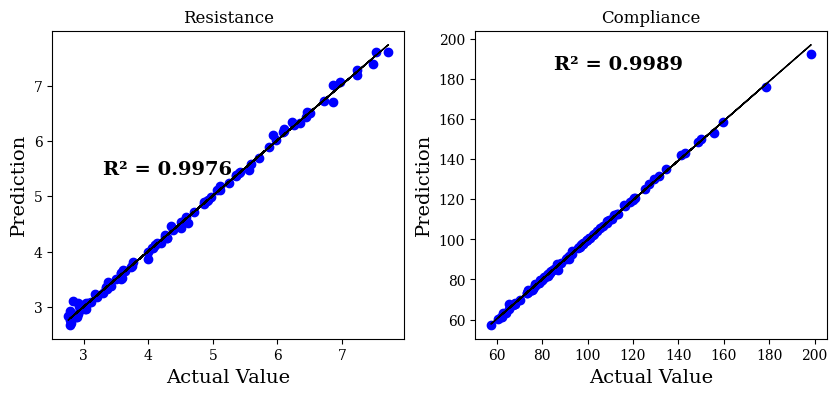

In [ ]:
# We plot the additional samples data and compare HF vs LF via mappiing
indice = [list(range(1,100+1))]

Y_pred_mean_c, Y_pred_var_c = lin_mf_model_c.predict(X_test_100)
Y_pred_mean_r, Y_pred_var_r = lin_mf_model_r.predict(X_test_100)

Y_test_100_C = Y_test_100[:,1]
Y_test_100_R = Y_test_100[:,0]

si = 14

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.scatter(Y_test_100_R[:100], Y_pred_mean_r[:100], color = 'blue')
ax1.set_xlabel('Actual Value',size = si)
ax1.set_ylabel('Prediction',size = si)
#ax1.set_aspect('equal', 'box')
ax1.set_title("Resistance")
r2_r = r2_score(Y_test_100_R[:100], Y_pred_mean_r[:100])
#print('\nr2: {}'.format(r2))
#ax1.annotate("r² = {:.3f}".format(r2_c),(98,128))


ax2.scatter(Y_test_100_C[:100], Y_pred_mean_c[:100], color = 'blue')
ax2.set_xlabel('Actual Value',size = si)
ax2.set_ylabel('Prediction',size = si)
#ax2.set_aspect('equal', 'box')
ax2.set_title("Compliance")
r2_c = r2_score(Y_test_100_C[:100], Y_pred_mean_c[:100])

ax1.annotate("R² = {:.4f}".format(r2_r),(3.3,5.4),size = si,weight='bold')
ax2.annotate("R² = {:.4f}".format(r2_c),(85,185),size = si,weight='bold')
print(r2_r)
print(r2_c)

a1, b1 = np.polyfit(Y_test_100_R[:100], Y_pred_mean_r[:100],1)
ax1.plot(Y_test_100_R[:100], a1*Y_test_100_R[:100] + b1, color = 'k', linewidth = 1)
#ax1.text(3.3, 5.1, 'y = ' + '{:.3f}'.format(b1) + ' + {:.3f}'.format(a1) + 'x', size=12)

a2, b2 = np.polyfit(Y_test_100_C[:100], Y_pred_mean_c[:100],1)
ax2.plot(Y_test_100_C[:100], a2*Y_test_100_C[:100] + b2, color = 'k', linewidth = 1)
#ax2.text(85, 170, 'y = ' + '{:.3f}'.format(b1) + ' + {:.3f}'.format(a2) + 'x', size=12)

Then, we also evaluate the model performance on the HF testing dataset:

0.9960981854426333
0.9965094919125185


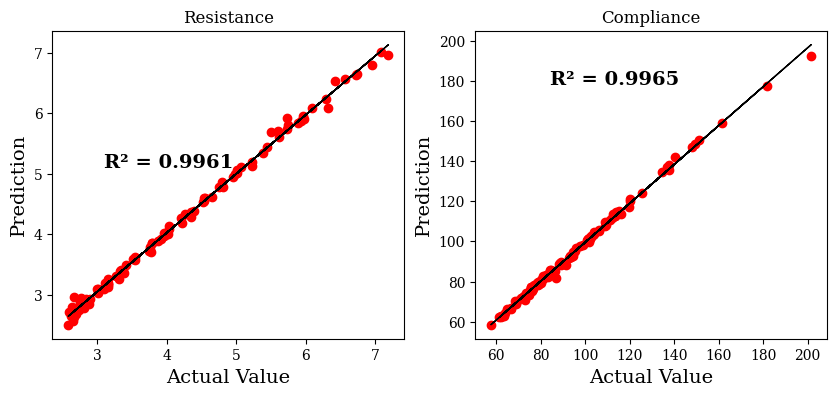

In [ ]:
# We plot the additional samples data and compare HF vs LF via mappiing
indice = [list(range(1,100+1))]

Y_pred_mean_c, Y_pred_var_c = lin_mf_model_c.predict(X_test_100)
Y_pred_mean_r, Y_pred_var_r = lin_mf_model_r.predict(X_test_100)

Y_test_100_C = Y_test_100[:,1]
Y_test_100_R = Y_test_100[:,0]

si = 14

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.scatter(Y_test_100_R[100:], Y_pred_mean_r[100:], color = 'red')
ax1.set_xlabel('Actual Value',size = si)
ax1.set_ylabel('Prediction',size = si)
#ax1.set_aspect('equal', 'box')
ax1.set_title("Resistance")

r2_r = r2_score(Y_test_100_R[100:], Y_pred_mean_r[100:])
#print('\nr2: {}'.format(r2))
#ax1.annotate("r² = {:.3f}".format(r2_c),(98,128))


ax2.scatter(Y_test_100_C[100:], Y_pred_mean_c[100:], color = 'red')
ax2.set_xlabel('Actual Value',size = si)
ax2.set_ylabel('Prediction',size = si)
#ax2.set_aspect('equal', 'box')
ax2.set_title("Compliance")

r2_c = r2_score(Y_test_100_C[100:], Y_pred_mean_c[100:])
#print('\nr2: {}'.format(r2))
ax1.annotate("R² = {:.4f}".format(r2_r),(3.1,5.1),size = si,weight='bold')
ax2.annotate("R² = {:.4f}".format(r2_c),(84,178),size = si,weight='bold')
print(r2_r)
print(r2_c)

a1, b1 = np.polyfit(Y_test_100_R[100:], Y_pred_mean_r[100:],1)
ax1.plot(Y_test_100_R[100:], a1*Y_test_100_R[100:] + b1, color = 'k', linewidth = 1)
#ax1.text(3.1, 4.8, 'y = ' + '{:.3f}'.format(b1) + ' + {:.3f}'.format(a1) + 'x', size=12)

a2, b2 = np.polyfit(Y_test_100_C[100:], Y_pred_mean_c[100:],1)
ax2.plot(Y_test_100_C[100:], a2*Y_test_100_C[100:] + b2, color = 'k', linewidth = 1)
#ax2.text(84, 165, 'y = ' + '{:.3f}'.format(b1) + ' + {:.3f}'.format(a2) + 'x', size=12)

We save the model predictions on the HF testing set

In [ ]:
# Export values
np.save('mfgp_var_C.npy', Y_pred_var_c)
np.save('mfgp_var_R.npy', Y_pred_var_r)
np.save('mfGP_C.npy', Y_pred_mean_c)
np.save('mfGP_R.npy', Y_pred_mean_r)

Along with the standard scaler

In [ ]:
from joblib import dump, load
dump(scaler, 'mfGP_std_scaler.bin', compress=True)

['mfGP_std_scaler.bin']

And the trained multi-fidelity GP models

In [ ]:
import pickle
with open('mfGP_c_model.pkl', 'wb') as file:
    pickle.dump(lin_mf_model_c, file)

with open('mfGP_r_model.pkl', 'wb') as file:
    pickle.dump(lin_mf_model_r, file)

Finally, we check that our trained surrogates predict the expected output data

In [ ]:
# for clarity we rename the linear multi-fidelity GP models to surrogate models.
surrogate_model_c = lin_mf_model_c # surrogate model for respiratory-system compliance
surrogate_model_r = lin_mf_model_r # surrogate model for airways resistance

In [ ]:
# we define a function to make evaluations in our surrogate models in an easy-way
def surrogate_evaluation(x1,x2,x3,x4,x5,x6,output):
  """
  Evaluate the specified model parameters and
  returns the lung response depending on the
  selected surrogate model.

  x1: c
  x2: beta
  x3: c1
  x4: c3
  x5: k
  x6: Ks

  output: respiratory-system compliance if 'c'
          airways resistance if 'r'
  """
  if output == 'c':
    surrogate_model = surrogate_model_c
  else:
    surrogate_model = surrogate_model_r
  matriz = np.zeros((1,6))
  matriz[0,0] = x1
  matriz[0,1] = x2
  matriz[0,2] = x3
  matriz[0,3] = x4
  matriz[0,4] = x5
  matriz[0,5] = x6
  scaled_matriz  = scaler.transform(matriz)
  x1 = scaled_matriz[0,0]
  x2 = scaled_matriz[0,1]
  x3 = scaled_matriz[0,2]
  x4 = scaled_matriz[0,3]
  x5 = scaled_matriz[0,4]
  x6 = scaled_matriz[0,5]
  x_params = np.array([x1, x2, x3, x4, x5, x6, 1])
  x_params = np.expand_dims(x_params, axis = 0)
  hf_mean_surrogate_model, hf_var_surrogate_model = surrogate_model.predict(x_params)
  Y = hf_mean_surrogate_model
  return Y

In [ ]:
# we perform evaluations using the input from an aleatory sample of our testing dataset
print(surrogate_evaluation(3.12121250e+02, 1.14983183e+00, 3.35565578e+02, 5.55432511e+00,
       1.16518345e+04, 8.38462002e-02, output='c'))

print(surrogate_evaluation(3.12121250e+02, 1.14983183e+00, 3.35565578e+02, 5.55432511e+00,
       1.16518345e+04, 8.38462002e-02, output='r'))

array([[98.96561577]])

## Cross-Validation (in testing set)

Additionally, we perform a cross-validation using different training sizes.

**Note**: *Take consideration that the following code block may take several hours to be executed*.

In [ ]:
split_list = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

random_list = np.arange(1,100+1,10)
RMSE_list_R = []
RMSE_list_C = []
std_R = []
std_C = []

for split in split_list:
  print("Train split: ", split)
  RMSE_inner_list_R = []
  RMSE_inner_list_C = []
  for random_number in random_list:
    # Split
    X_lf_train, X_lf_test = train_test_split(X_lf, train_size=split, shuffle=True, random_state=random_number) # this split the input data
    Y_lf_train, Y_lf_test = train_test_split(Y_lf, train_size=split, shuffle=True, random_state=random_number) # this split the output data

    X_hf_train, X_hf_test = train_test_split(X_hf, train_size=split, shuffle=True, random_state=random_number) # this split the input data
    Y_hf_train, Y_hf_test = train_test_split(Y_hf, train_size=split, shuffle=True, random_state=random_number) # this split the output data

    X_hf_test_100 = X_hf_100
    Y_hf_test_100 = Y_hf_100

    X_lf_test_100 = X_lf_100
    Y_lf_test_100 = Y_lf_100


    # Normalize
    scaler = StandardScaler()

    X_lf_train = scaler.fit_transform(X_lf_train)
    X_lf_test = scaler.transform(X_lf_test)
    X_lf_test_100 = scaler.transform(X_lf_test_100)

    X_hf_train = scaler.fit_transform(X_hf_train)
    X_hf_test = scaler.transform(X_hf_test)
    X_hf_test_100 = scaler.transform(X_hf_test_100)


    # Convert
    X_train, Y_train = convert_xy_lists_to_arrays([X_lf_train, X_hf_train], [Y_lf_train, Y_hf_train])
    X_test, Y_test = convert_xy_lists_to_arrays([X_lf_test, X_hf_test], [Y_lf_test, Y_hf_test])

    X_test_100, Y_test_100 = convert_xy_lists_to_arrays([X_lf_test_100, X_hf_test_100], [Y_lf_test_100, Y_hf_test_100])


    # Train
    input_dim = X_train.shape[1]-1
    Y_train_r = Y_train[:,0][:,np.newaxis]
    Y_train_c = Y_train[:,1][:,np.newaxis]

    kernels_c = [GPy.kern.RBF(input_dim), GPy.kern.RBF(input_dim)]
    kernels_r = [GPy.kern.RBF(input_dim), GPy.kern.RBF(input_dim)]
    lin_mf_kernel_c = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels_c)
    lin_mf_kernel_r = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels_r)

    gpy_lin_mf_model_c = GPyLinearMultiFidelityModel(X_train, Y_train_c, lin_mf_kernel_c, n_fidelities=2)
    gpy_lin_mf_model_c.mixed_noise.Gaussian_noise.fix(0)
    gpy_lin_mf_model_c.mixed_noise.Gaussian_noise_1.fix(0)
    gpy_lin_mf_model_r = GPyLinearMultiFidelityModel(X_train, Y_train_r, lin_mf_kernel_r, n_fidelities=2)
    gpy_lin_mf_model_r.mixed_noise.Gaussian_noise.fix(0)
    gpy_lin_mf_model_r.mixed_noise.Gaussian_noise_1.fix(0)

    lin_mf_model_c = model_c = GPyMultiOutputWrapper(gpy_lin_mf_model_c, 2, n_optimization_restarts=10)
    lin_mf_model_r = model_r = GPyMultiOutputWrapper(gpy_lin_mf_model_r, 2, n_optimization_restarts=10)

    lin_mf_model_c.optimize()
    #clear_output()
    print('Compliance model optimized')
    lin_mf_model_r.optimize()
    #clear_output()
    print('Resistance model optimized')


    # Evaluate
    Y_pred_mean_c, Y_pred_var_c = lin_mf_model_c.predict(X_test_100)
    Y_pred_mean_r, Y_pred_var_r = lin_mf_model_r.predict(X_test_100)
    # H-F predictions
    print("H-F predictions")
    indice_hf_begins = X_lf_test.shape[0]
    mse_R = mean_squared_error(Y_test_100[indice_hf_begins:,0], Y_pred_mean_r[indice_hf_begins:])
    print('\nMSE R: {}'.format(mse_R))
    mse_C = mean_squared_error(Y_test_100[indice_hf_begins:,1], Y_pred_mean_c[indice_hf_begins:])
    print('\nMSE C: {}'.format(mse_C))
    RMSE_inner_list_R.append(np.sqrt(mse_R))
    RMSE_inner_list_C.append(np.sqrt(mse_C))
  RMSE_list_R.append(np.average(RMSE_inner_list_R))
  RMSE_list_C.append(np.average(RMSE_inner_list_C))
  print(RMSE_inner_list_R)
  print(RMSE_inner_list_C)
  std_R.append(np.std(RMSE_inner_list_R))
  std_C.append(np.std(RMSE_inner_list_C))

#clear_output()

for i in range(len(split_list)):
  print("Train split: ", split_list[i], "||    MSE R: ", RMSE_list_R[i], "||    MSE C: ", RMSE_list_C[i], "||    std R: ", std_R[i], "||    std C: ", std_C[i])

In [ ]:
# Export values
np.save('RMSE_R_mfGP.npy', RMSE_list_R)
np.save('RMSE_C_mfGP.npy', RMSE_list_C)
np.save('std_R_mfGP.npy', std_R)
np.save('std_C_mfGP.npy', std_C)